In [76]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


## Part I

In [77]:
## Looad points 

with open('points.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

blue_points = loaded_data['blue_points']
one_blue = blue_points[0]
print(one_blue)
black_points = loaded_data['black_points']
one_black = black_points[0]
print(one_black)
print(blue_points.shape)
print(black_points.shape)


print(np.array_equal(blue_points, black_points))

[ 1.  5. 10.]
[ 1.  1. 10.]
(1000000, 3)
(1000000, 3)
False


In [78]:
# Define camera parameters
camera_center = np.array([0, 0, 0])
focal_length = 1

# Define image planes
# Standard plane perpendicular to the Z-axis
standard_plane_z = 1

# Custom plane equation (ax + by + cz + d = 0)
# Example: a plane rotated around the Y-axis by 45 degrees
a, b, c, d = 1, 0, 1, -1  # coefficients for the plane equation

### Projection to standard plane

In [79]:
def project_points_to_standard_plane(points, camera_center, focal_length, plane_z):
    projected_points = []
    for point in points:
        '''
        direction vector = A ray starts from the camera center and travels infinitely through many points in space
        to find the ray that hits a point,  we subtract the point from the camera center to the point itself, this gives us the direction vector
        
        scale: this is used to determine how far along the direction vector we need to travel to reach the image plane. This would help us to find the intersection point of the ray with the plane
        
        It is just the same ray that we have calculated, but we are scaling it to reach the image plane. The scale is calculated by dividing the distance of the plane from the camera center by the z-component of the direction vector
        
        intersection: This is the point where the ray intersects the image plane. It is calculated by adding the scaled direction vector to the camera center
        
        The intersection point represents the 3D co-ordinates of the point on the image plane. But we need to convert this into 2D.
        
        '''
        # Calculate the direction vector from the camera center to the point = it describes the ray from the camera to the point
        direction_vector = point - camera_center
        # Calculate the intersection point with the plane
        scale = (plane_z - camera_center[2]) / direction_vector[2]
        intersection_point = camera_center + scale * direction_vector # This is the ray equation
        # Calculate the projection of the intersection point with the plane onto the image plane
        projection = focal_length * intersection_point / intersection_point[2]
        projection = projection[:2]  # Keep only the x and y coordinates
        projected_points.append(projection)
    return np.array(projected_points)

project_points_to_standard_plane(blue_points, camera_center, focal_length, standard_plane_z)

array([[1.00000000e-01, 5.00000000e-01],
       [5.00000000e-02, 2.50000000e-01],
       [3.33333333e-02, 1.66666667e-01],
       ...,
       [1.00000200e-07, 5.00001000e-07],
       [1.00000100e-07, 5.00000500e-07],
       [1.00000000e-07, 5.00000000e-07]], shape=(1000000, 2))

#### Plotting the projections

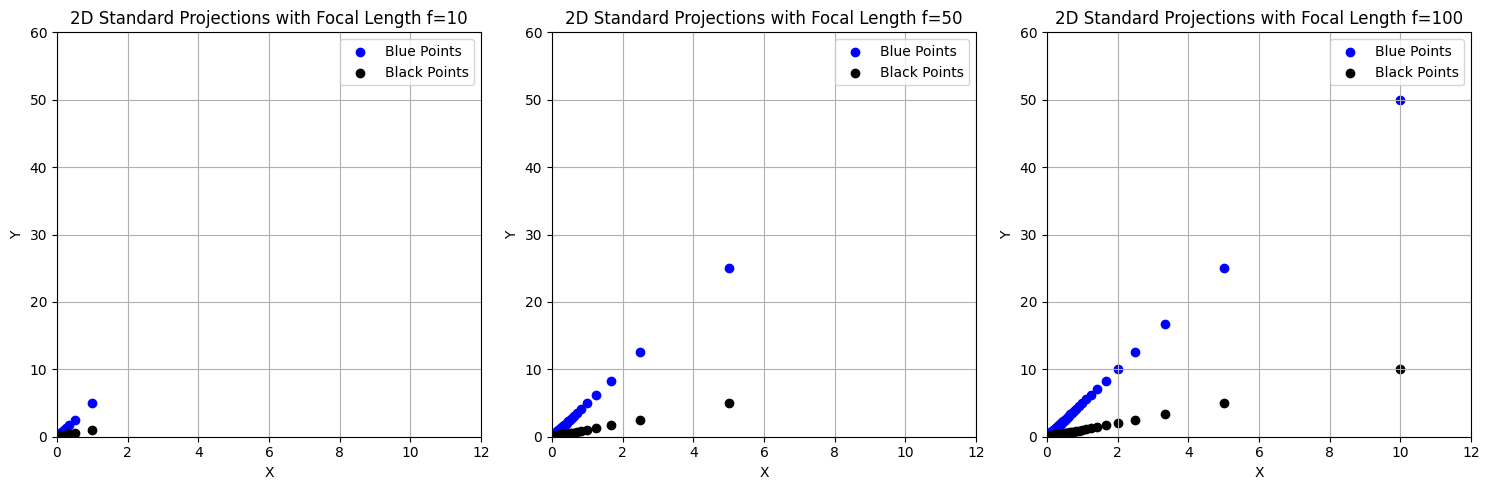

In [80]:
focal_lengths = [10, 50, 100]
Z0 = 1


# Creating a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, f in enumerate(focal_lengths):
    blue_points_proj = project_points_to_standard_plane(blue_points, camera_center, f, Z0)
    black_points_proj = project_points_to_standard_plane(black_points, camera_center, f, Z0)
    
    ax = axes[idx]  # Getting the subplot axis

    # Plotting the  blue and black points for each focal length on the current subplot
    ax.scatter(blue_points_proj[:, 0], blue_points_proj[:, 1], color='blue', label='Blue Points')
    ax.scatter(black_points_proj[:, 0], black_points_proj[:, 1], color='black', label='Black Points')

    # Set the limits, titles, and labels for each subplot
    ax.set_xlim(0.00, 12)
    ax.set_ylim(0.00, 60)
    ax.set_title(f'2D Standard Projections with Focal Length f={f}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
    ax.grid(True)

# Adjust layout to prevent overlap between subplots
plt.tight_layout()

# Show the plot
plt.show()


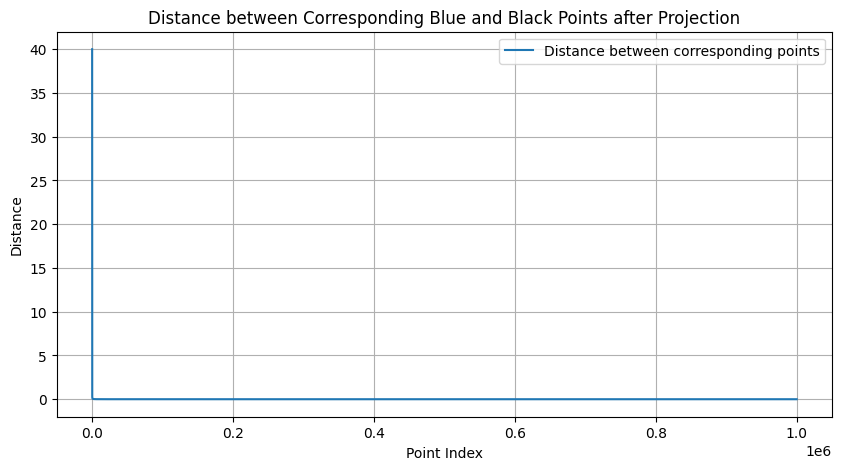

In [81]:
## TODO calculate the distance between each corresponding pair of blue and black  point after projection
## Plot the distance 
# Calculate the distance between each corresponding pair of blue and black points after projection
distances = np.linalg.norm(blue_points_proj - black_points_proj, axis=1)


# Plot the distances
plt.figure(figsize=(10, 5))
plt.plot(distances, label='Distance between corresponding points')
plt.xlabel('Point Index')
plt.ylabel('Distance')
plt.title('Distance between Corresponding Blue and Black Points after Projection')
plt.legend()
plt.grid(True)
plt.show()

### Plotting to a titled Image Plane

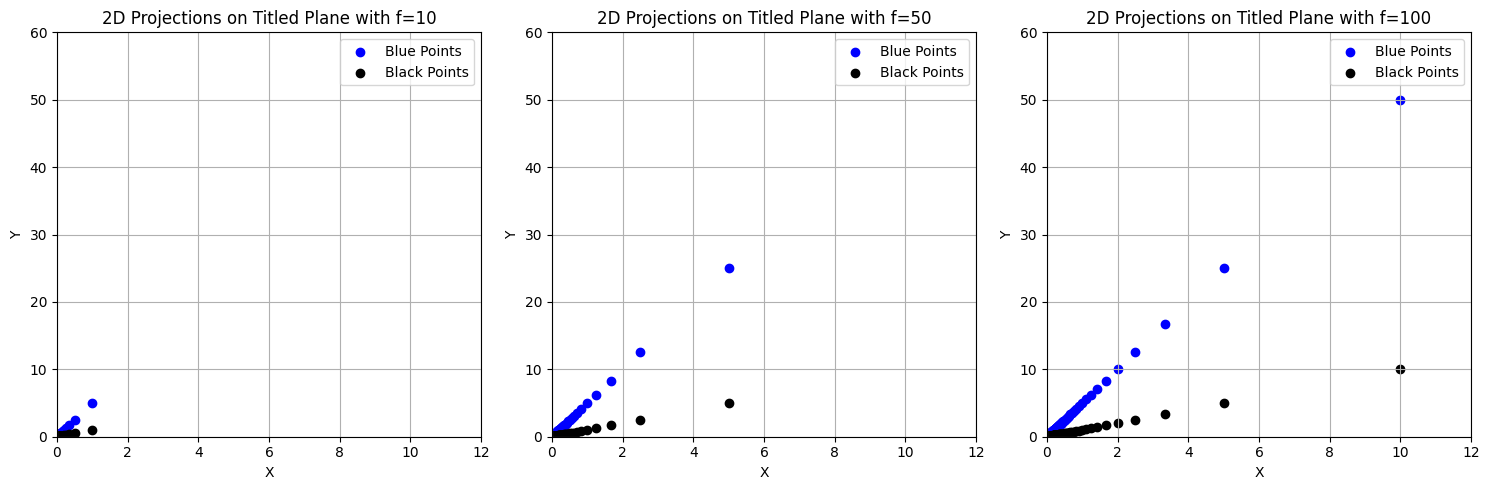

In [82]:
def project_points_to_titled_plane(points, camera_center, focal_length, a, b, c, d):
    '''
    a, b, c, d: coefficients for the plane equation ax + by + cz + d = 0
    a,b and c defines the orientation(normal vector) of the plane
    d is the distance of the plane from the origin
    
    Like the standard plane, we calculate the direction vector of the ray from the camera center to the point
        - to find the direction vector, we subtract the point from the camera center
    We calculate the scale to determine how far along the direction vector we need to travel to reach the image plane
        - the scale is calculated by dividing the distance of the plane from the camera center by the dot product of the direction vector and the normal vector of the plane
    We calculate the intersection point of the ray with the plane
        - the intersection point is calculated by adding the scaled direction vector to the camera center
    We calculate the projection of the intersection point with the plane onto the image
        - the projection is calculated by multiplying the focal length by the intersection point and dividing by the z-component of the intersection point
    
    so the only difference between the standard plane and the titled plane is the calculation of the scale
    
    
    '''
    projected_points = []
    for point in points:
        direction_vector = point - camera_center
        scale = (d - np.dot([a, b, c], camera_center)) / np.dot([a, b, c], direction_vector)
        intersection_point = camera_center + scale * direction_vector
        projection = focal_length * intersection_point / intersection_point[2]
        projection = projection[:2]
        projected_points.append(projection)
    return np.array(projected_points)

project_points_to_titled_plane(blue_points, camera_center, focal_length, a, b, c, d)
focal_lengths = [10, 50, 100]
Z0 = 1

# Create a single figure with 3 subplots arranged in 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, f in enumerate(focal_lengths):
    # Project blue and black points onto the titled plane
    blue_points_proj = project_points_to_titled_plane(blue_points, camera_center, f, a, b, c, d)
    black_points_proj = project_points_to_titled_plane(black_points, camera_center, f, a, b, c, d)
    
    ax = axes[idx]  # Get the subplot axis

    # Plot blue and black points for each focal length on the current subplot
    ax.scatter(blue_points_proj[:, 0], blue_points_proj[:, 1], color='blue', label='Blue Points')
    ax.scatter(black_points_proj[:, 0], black_points_proj[:, 1], color='black', label='Black Points')

    # Set the limits, titles, and labels for each subplot
    ax.set_title(f'2D Projections on Titled Plane with f={f}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(0.00, 12)
    ax.set_ylim(0.00, 60)
    ax.legend()
    ax.grid(True)

# Adjust layout to prevent overlap between subplots
plt.tight_layout()

# Show the plot
plt.show()

Analysis of Parameters

- **How does changing the focal length f impact the projection?**
    - Changing the focal length f affects the scale of the projection. A larger focal length results in a larger projection, making the points appear further apart. Conversely, a smaller focal length results in a smaller projection, making the points appear closer together. This is evident from the graphs plotted above (They are all using the same scale), You can see that as the focal length increases, the distance betweeen any two points (black and correspondin blue) increases.

- **How does the position and orientation of the image plane affect the results?**
    - The position and orientation of the image plane determine where the points are projected. A standard plane perpendicular to the Z-axis results in a straightforward projection, while a tilted plane changes the perspective and can distort the projection based on the plane's orientation.

- **Compare projections for the two image planes and discuss the differences.**
    - Projections on the standard plane are simpler and maintain the relative distances between points more consistently. Projections on the tilted plane can introduce distortions due to the angle of the plane, which can affect the relative positions and distances between points.

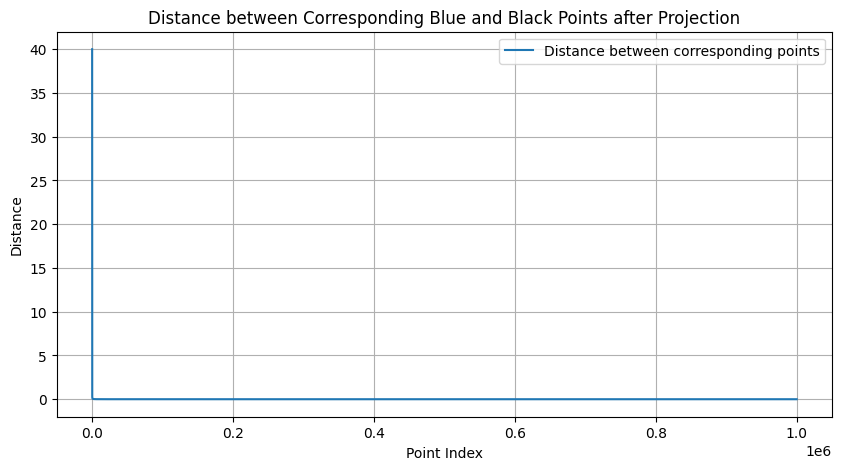

In [90]:
## TODO calculate the distance between each corresponding pair of blue and black  point after projection
## Plot the distance 
# Calculate the distance between each corresponding pair of blue and black points after projection
distances = np.linalg.norm(blue_points_proj - black_points_proj, axis=1)

# Plot the distances
plt.figure(figsize=(10, 5))
plt.plot(distances, label='Distance between corresponding points')
plt.xlabel('Point Index')
plt.ylabel('Distance')
plt.title('Distance between Corresponding Blue and Black Points after Projection')
plt.legend()
plt.grid(True)
plt.show()

## Ideal points
Calculate the distance between the first black point and the first blue point as well as the last blue and black point (you can calculate this by taking the L2 norm of a vector formed by this pair of points. Repeat same for the points just on the image plane just before the pixel mapping.


In [84]:
# Calculate L2 norm for the first and last points in 3D space
distance_first_3d = np.linalg.norm(one_blue - one_black)
distance_last_3d = np.linalg.norm(blue_points[-1] - black_points[-1])

# Calculate L2 norm for the first and last points in 2D projection
distance_first_2d = np.linalg.norm(blue_points_proj[0] - black_points_proj[0])
distance_last_2d = np.linalg.norm(blue_points_proj[-1] - black_points_proj[-1])

# Print the distances
print(f"Distance between first points in 3D space: {distance_first_3d}")
print(f"Distance between last points in 3D space: {distance_last_3d}")
print(f"Distance between first points in 2D projection: {distance_first_2d}")
print(f"Distance between last points in 2D projection: {distance_last_2d}")



Distance between first points in 3D space: 4.0
Distance between last points in 3D space: 4.0
Distance between first points in 2D projection: 40.0
Distance between last points in 2D projection: 3.9999999999999996e-05



**Observation:**
- The distances in 3D space and 2D projection are different.

**Reason:**
- The difference arises because the projection process involves scaling and transforming the points based on the camera parameters and the image plane. This transformation can change the relative distances between points.

### OTHER STUFF

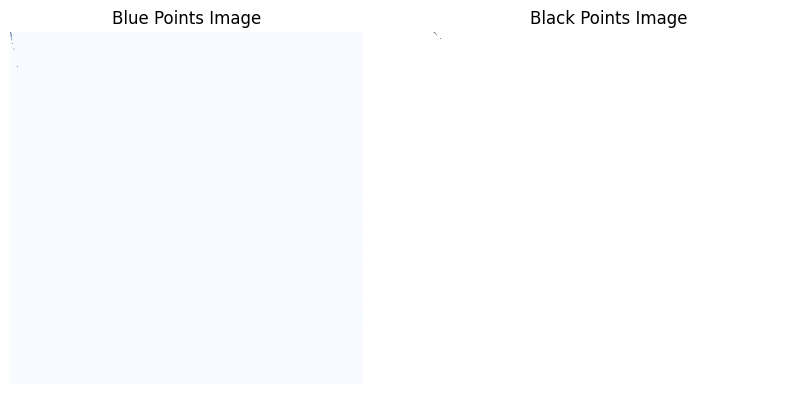

In [86]:
## #TODO Convert those projects to an image take note of the scale for simplicity you can downsample to an image of 500 by 500
## #TODO plot the image and include in your report

def convert_points_to_image(points, image_size):
    
    '''
    This function converts the projected points to an image, it takes our 2D projected points and converts them into image representation of size image size by image size
    Each point is mapped to a corresponding pixel on the image grid
    '''
    image = np.zeros((image_size, image_size))
    points = np.round(points).astype(int)
    for point in points:
        x, y = point
        if 0 <= x < image_size and 0 <= y < image_size:
            image[y, x] = 1
    return image

image_size = 500
blue_image = convert_points_to_image(blue_points_proj, image_size)
black_image = convert_points_to_image(black_points_proj, image_size)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(blue_image, cmap='Blues')
plt.title('Blue Points Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(black_image, cmap='Greys')
plt.title('Black Points Image')
plt.axis('off')
plt.show()


### PART II Image Demosaicing

Bayer Image with missing pixels


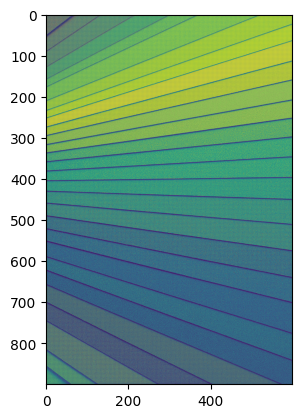

In [87]:
with open('data.pkl', 'rb') as file:
    loaded_data = pickle.load(file)
print("Bayer Image with missing pixels")
plt.imshow(loaded_data)

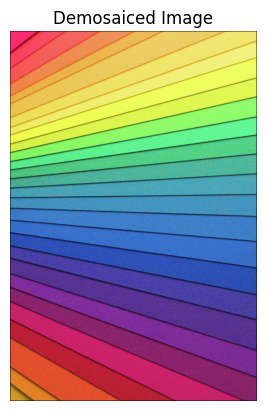

In [88]:


def bayer2rgb(bayer_image):
    """Performs bilinear interpolation demosaicing on a Bayer-patterned image."""
    
    # Get image dimensions
    height, width = bayer_image.shape[0], bayer_image.shape[1]

    # Initialize empty RGB channels
    R = np.zeros((height, width), dtype=np.float32)
    G = np.zeros((height, width), dtype=np.float32)
    B = np.zeros((height, width), dtype=np.float32)

    # The  Bayer RGGB pattern is as follows:
    # R G
    # G B
    
    '''
    Red pixels are at even positions in both rows and columns
    Blue pixels are at odd positions in both rows and columns
    Green pixels are at the intersection of odd rows and even columns or even rows and odd columns
    
    '''

    # Interpolate Green Channel (cross pattern)
    # Green occurs at even rows and columns
    for row in range(1, height - 1):
        for column in range(1, width - 1):
            ''' 
            We interpolate the green channel by averaging the values of the pixels above, below, to the left, and to the right of the current pixel
            We check if the pixel is red or blue by checking if the row and column are both even or odd
            if they are we interpolate the green channel by averaging the values of the pixels above, below, to the left, and to the right of the current pixel
            else we leave the pixel as it is
            '''
            if (row % 2 == 0 and column % 2 == 0) or (row % 2 == 1 and column % 2 == 1):
                # Red or Blue pixels -> interpolate G
                G[row, column] = (bayer_image[row - 1, column] + bayer_image[row + 1, column] + bayer_image[row, column - 1] + bayer_image[row, column + 1]) / 4
            else:
                # Already a green pixel
                G[row, column] = bayer_image[row, column]

    # Interpolate Red and Blue channels
    for row in range(1, height - 1):
        for column in range(1, width - 1):
            ''' 
            We interpolate the red and blue channels by averaging the values of the pixels diagonally opposite to the current pixel
            We check if the pixel is red or blue by checking if the row and column are both even or odd
            '''
            if row % 2 == 0 and column % 2 == 0:  # Red pixel
                ''' 
                We have already interpolated the green for this pixel location
                We leave the red pixel as it is
                We interpolate the blue pixel by averaging the values of the pixels diagonally opposite to the current pixel - the 4 pixels around it
                '''
                R[row, column] = bayer_image[row, column]
                B[row, column] = (bayer_image[row - 1, column - 1] + bayer_image[row - 1, column + 1] + bayer_image[row + 1, column - 1] + bayer_image[row + 1, column + 1]) / 4
            elif row % 2 == 1 and column % 2 == 1:  # Blue pixel
                ''' 
                We have already interpolated the green for this pixel location
                We leave the blue pixel as it is
                We interpolate the red pixel by averaging the values of the pixels diagonally opposite to the current pixel - the 4 pixels around it
                '''
                B[row, column] = bayer_image[row, column]
                R[row, column] = (bayer_image[row - 1, column - 1] + bayer_image[row - 1, column + 1] + bayer_image[row + 1, column - 1] + bayer_image[row + 1, column + 1]) / 4
            elif row % 2 == 0 and column % 2 == 1:  # Green pixel in Red row
                ''' 
                This is the green pixel in the red row
                To interpolate the red pixel, we average the values of the pixels before and after the current pixel
                To interpolate the blue pixel, we average the values of the pixels above and below the current pixel
                '''
                R[row, column] = (bayer_image[row, column - 1] + bayer_image[row, column + 1]) / 2
                B[row, column] = (bayer_image[row - 1, column] + bayer_image[row + 1, column]) / 2
            else:  # Green pixel in Blue row
                ''' 
                This is the green pixel in the blue row
                To interpolate the red pixel, we average the values of the pixels above and below the current pixel
                To interpolate the blue pixel, we average the values of the pixels before and after the current pixel
                '''
                B[row, column] = (bayer_image[row, column - 1] + bayer_image[row, column + 1]) / 2
                R[row, column] = (bayer_image[row - 1, column] + bayer_image[row + 1, column]) / 2
                
    # We return the stacked R, G, and B channels as an RGB image
    return np.stack([R, G, B], axis=-1).astype(np.uint8)

# Apply demosaicing
color_image = bayer2rgb(loaded_data)

# Display the result
plt.imshow(color_image)
plt.title("Demosaiced Image")
plt.axis('off')
plt.show()


Here is the result for your reference in evaluating your performance
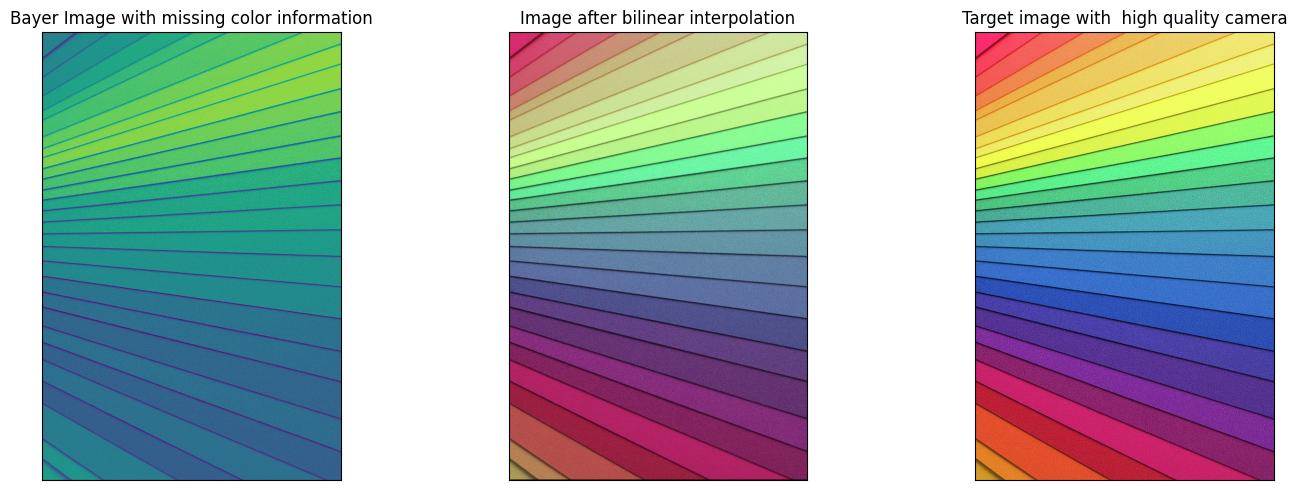

#### Limitations of Bilinear Interpolation
- **Color Artifacts**: Bilinear interpolation can introduce color artifacts, such as zippering and false colors, especially in regions with high-frequency details.
- **Blurring**: The algorithm tends to blur edges and fine details, reducing the overall sharpness of the image.

#### Potential Improvements
1. **Edge-Aware Interpolation**: Incorporating edge detection into the interpolation process can help preserve edges and reduce artifacts. Algorithms like Adaptive Homogeneity-Directed (AHD) demosaicing can be used.
2. **Frequency-Based Methods**: Using frequency domain information can improve the reconstruction of high-frequency details. Methods like the Discrete Wavelet Transform (DWT) can be explored.
3. **Machine Learning Approaches**: Deep learning methods, such as Convolutional Neural Networks (CNNs), have shown promise in improving image quality. These methods can learn complex patterns and provide better results than traditional algorithms.

#### Other Demosaicing Algorithms
1. **Adaptive Homogeneity-Directed (AHD) Demosaicing**
    - **Advantages**: Better preservation of edges and reduction of color artifacts.
    - **Limitations**: More computationally intensive than bilinear interpolation.

2. **Frequency-Based Methods (e.g., DWT)**
    - **Advantages**: Improved reconstruction of high-frequency details.
    - **Limitations**: Requires more computational resources and can be complex to implement.

3. **Deep Learning Methods**
    - **Advantages**: Superior image quality and artifact reduction. Can learn complex patterns and adapt to various image characteristics.
    - **Limitations**: Requires large amounts of labeled data for training. Computationally expensive and may not be feasible in resource-constrained environments.

#### Constraints Posed by Data Availability
- **Data Scarcity**: In regions with limited resources, such as certain areas in Africa, obtaining large amounts of labeled data for training deep learning models can be challenging.
- **Resource Constraints**: High computational requirements of deep learning methods may not be feasible in environments with limited access to advanced hardware.
